#**Welcome to our second stock model**

In this model, we will analyze the one-month history of a stock to predict whether its price will go up or down. We'll use historical data from the stock market to train our model and make predictions about the future direction of the stock price.

By analyzing patterns and trends in the stock's historical data, our model aims to capture important factors that can indicate whether the stock price is likely to increase or decrease in the near term.

Predicting stock price movements can be challenging, as it depends on various factors such as market conditions, economic indicators, and company-specific news. However, our model will use advanced techniques to analyze historical data and make predictions based on patterns and trends observed in the market.

Please provide us with the name or ticker symbol of the stock you would like to analyze, and we'll start the prediction process.

# **Importing libaries**

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterSampler


These imported libraries provide a solid foundation for fetching the stock data, splitting it for training and testing, training a regression model, and evaluating its performance.

# **Pulling the data**

In [ ]:
# Define the stock symbol and timeframe
stock_symbol = "AAPL"
timeframe = "1mo"
prediction_days = 2  # Number of days to predict into the future

# Fetch the latest stock data using yfinance API
stock_data = yf.download(stock_symbol, period=timeframe, progress=False)

# Preprocess the data
stock_data = stock_data.dropna()  # Remove missing values


In this code, we're interested in studying the stock of Apple Inc. (AAPL) over the past month. We want to predict the stock price for the next 2 days.

To do this, we need to get the historical stock data. We use a special tool called Yahoo Finance to fetch this data for us. Once we have the data, we check if there are any missing values and remove them to make sure our analysis is accurate.

In simpler terms, we're getting information about how Apple's stock price has changed over the past month, and we want to use that information to guess what the price might be in the next 2 days.

# **Using the data**

In [ ]:
# Add a column for the previous day's closing price
stock_data['PrevClose'] = stock_data['Close'].shift(1)

# Add a column for the SMA
stock_data['SMA_10'] = stock_data['Close'].rolling(window=10).mean()

# Add a column for the EMA
stock_data['EMA_10'] = stock_data['Close'].ewm(span=10, adjust=False).mean()

# Add a column for the RSI
delta = stock_data['Close'].diff()
gain = delta.mask(delta < 0, 0)
loss = -delta.mask(delta > 0, 0)
average_gain = gain.rolling(window=14).mean()
average_loss = loss.rolling(window=14).mean()
rs = average_gain / average_loss
rsi = 100 - (100 / (1 + rs))
stock_data['RSI'] = rsi

# Add a column for the MACD
ema_12 = stock_data['Close'].ewm(span=12, adjust=False).mean()
ema_26 = stock_data['Close'].ewm(span=26, adjust=False).mean()
macd = ema_12 - ema_26
signal_line = macd.ewm(span=9, adjust=False).mean()
stock_data['MACD'] = macd
stock_data['Signal Line'] = signal_line

# Add a column for the Bollinger Bands
rolling_mean = stock_data['Close'].rolling(window=20).mean()
rolling_std = stock_data['Close'].rolling(window=20).std()
upper_band = rolling_mean + (2 * rolling_std)
lower_band = rolling_mean - (2 * rolling_std)
stock_data['Upper Band'] = upper_band
stock_data['Lower Band'] = lower_band

In [ ]:
# Split the data into features (X) and target variable (y)
X = stock_data[['PrevClose', 'SMA_10', 'EMA_10', 'RSI', 'MACD', 'Upper Band', 'Lower Band']].iloc[1:].values
y = stock_data['Close'].iloc[1:].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In this code, we're adding new columns to the stock data to help us understand and predict the behavior of Apple's stock.

The "Previous Close" column tells us the price of the stock on the day before. We can compare this with the current day's price to see if it went up or down.

The "SMA" column gives us the average price of the stock over the past 10 days. It helps us see the overall trend of the stock's price.

The "EMA" column is another type of average that focuses more on recent prices. It helps us see short-term trends in the stock's price.

The "RSI" column measures if the stock is overbought or oversold. It looks at recent price changes to determine if the stock is likely to go up or down in the near future.

The "MACD" column shows the difference between two averages of the stock's price. It helps us identify potential changes in the stock's trend.

The "Bollinger Bands" columns show the upper and lower bounds of the stock's price based on its historical volatility. They help us see if the stock is trading within a normal range or if it's likely to move towards an extreme.

Finally, we split the data into two parts: a training set and a testing set. This allows us to build a model using the training data and check how well it predicts the stock's price using the testing data.

# **Creating the model**

In [ ]:
model =XGBRegressor()
# Define the parameter distributions
param_distributions = {
    'n_estimators': list(range(50, 1001, 50)),
    'learning_rate': [0.001, 0.01, 0.1],
    'max_depth': list(range(3, 11)),
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0, 0.1, 0.5, 1.0],
    'min_child_weight': [1, 3, 5]
}
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.001, 0.01, 0.1]
}


# Set the number of samples to generate
n_samples = 50

# Generate random parameter samples
param_samples = list(ParameterSampler(param_distributions, n_iter=n_samples, random_state=42))

# Initialize the best parameters list
best_params_array = []

# Perform grid search
best_score = None
best_params = None

for params in param_samples:
    model.set_params(**params)
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)

    if best_score is None or score > best_score:
        best_score = score
        best_params = params

# Append the best parameters to the list
best_params_array.append(best_params)

# Print the best parameters
print("Best Parameters:", best_params)

# Create an instance of the XGBoost model
model = XGBRegressor(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best hyperparameter values and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Train the best model
best_model.fit(X_train, y_train)

# Evaluate the best model
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("Best Hyperparameters:", best_params)
print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)

In this code, we're training a machine learning model called XGBoost to predict the stock price of Apple Inc. (AAPL). We want to find the best combination of hyperparameters for the model to improve its performance.

First, we define a range of values for various hyperparameters, such as the number of estimators, learning rate, maximum depth, and more. These hyperparameters control the behavior of the XGBoost model. We also set the number of parameter samples we want to generate.

Next, we perform a random search over the parameter space by generating random combinations of hyperparameters from the defined ranges. For each combination, we train an XGBoost model and evaluate its performance using the testing data.

We keep track of the best performing model and its corresponding hyperparameters. After trying different combinations, we print the best hyperparameters found during the random search.

Then, we create a new instance of the XGBoost model and perform a grid search with cross-validation. This time, we use a predefined grid of hyperparameters and evaluate their performance using cross-validation. This helps us select the best hyperparameters more reliably.

We retrieve the best hyperparameters and the corresponding model from the grid search. We train the best model on the training data and evaluate its performance by predicting the stock prices for both the training and testing data. We calculate the root mean squared error (RMSE) between the predicted prices and the actual prices.

Finally, we print the best hyperparameters, the RMSE for the training data, and the RMSE for the testing data. This gives us an idea of how well the model is performing in terms of predicting the stock prices of Apple Inc.

Overall, the code performs a search for the best hyperparameters and trains a model to predict stock prices based on these optimized parameters.
# **Applying the model**

In [ ]:

# Retrieve the best hyperparameters from the best_params_array
best_params = best_params_array[0]  # Assuming there is only one set of best parameters

# Train the XGBoost model with the best hyperparameters
model = XGBRegressor(
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    random_state=42
)

model.fit(X_train, y_train)


# Evaluate the model
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)


Train RMSE: 3.580054071883114
Test RMSE: 0.3537325140228243


In [ ]:

# Predict future prices
last_data_point = stock_data[['PrevClose', 'SMA_10', 'EMA_10', 'RSI', 'MACD', 'Upper Band', 'Lower Band']].iloc[-1:].values
predictions = []
for _ in range(prediction_days):
    prediction = model.predict(last_data_point)[0]
    predictions.append(prediction)
    last_data_point = np.array([[
        prediction,
        stock_data['SMA_10'].iloc[-prediction_days:][0],
        stock_data['EMA_10'].iloc[-prediction_days:][0],
        stock_data['RSI'].iloc[-prediction_days:][0],
        stock_data['MACD'].iloc[-prediction_days:][0],
        stock_data['Upper Band'].iloc[-prediction_days:][0],
        stock_data['Lower Band'].iloc[-prediction_days:][0]
    ]])

# Print the predicted closing prices for the next `prediction_days`
print("Predicted closing prices for the next", prediction_days, "days:")
for i, prediction in enumerate(predictions):
    print("Day", i+1, ":", prediction)


Predicted closing prices for the next 2 days:
Day 1 : 185.94946
Day 2 : 185.6974


In this code, we are using the best hyperparameters obtained from the previous step to train the XGBoost model. Then, we evaluate the model's performance by predicting the stock prices for both the training and testing datasets.

Next, we proceed to predict the future stock prices for the specified number of prediction_days. We start by taking the last available data point and use it as input to the trained model to make a prediction. We store this prediction and then update the input data point using the predicted value, along with the corresponding historical values of the other features (such as SMA, EMA, RSI, MACD, Upper Band, and Lower Band) from the stock data.

Finally, we print the predicted closing prices for each day in the future, based on the number of prediction_days specified.

It's important to note that predicting future stock prices is a challenging task and involves a level of uncertainty. The predictions provided should be considered as estimates and not as certain outcomes. Various factors can influence stock prices, and it's recommended to perform thorough analysis and consult multiple sources before making any investment decisions based on these predictions.

# **Plotting the data**

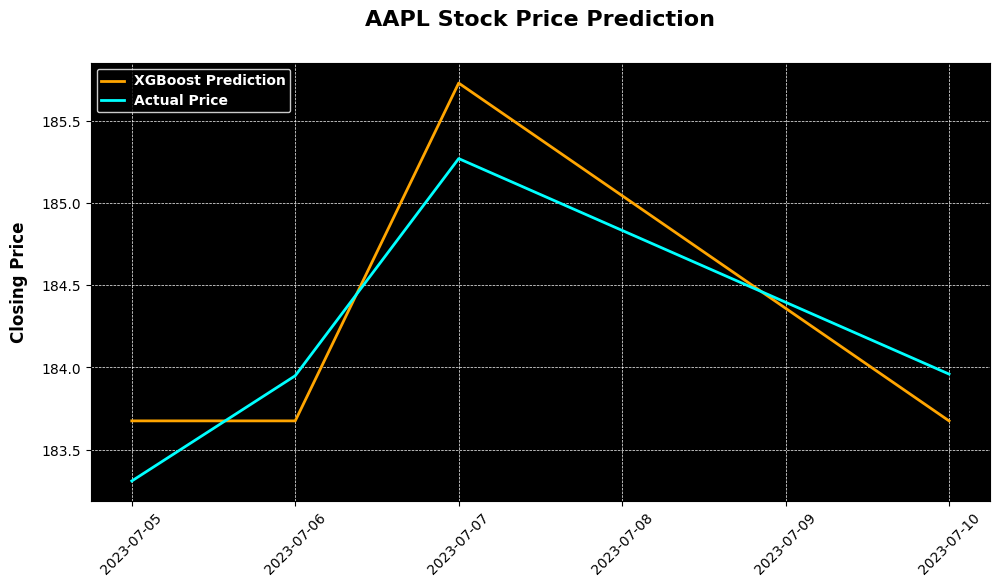

In [ ]:
import matplotlib.dates as mdates
plt.figure(figsize=(10, 6))
ax = plt.gca()

# Set the background color to black
ax.set_facecolor('black')

# Customize the line colors and styles
prediction_color = 'orange'
actual_color = 'cyan'
line_width = 2

# Plot the XGBoost predictions
plt.plot(stock_data.index[-len(y_test_pred):], y_test_pred, color=prediction_color, linewidth=line_width, linestyle='-', label='XGBoost Prediction')

# Plot the actual stock prices
plt.plot(stock_data.index[-len(y_test):], y_test, color=actual_color, linewidth=line_width, linestyle='-', label='Actual Price')

# Set the x-axis label, y-axis label, and plot title with white text inside the graph area
plt.text(-0.08, 0.5, 'Closing Price', color='black', ha='center', va='center', rotation='vertical', transform=ax.transAxes, fontsize=12, fontweight='bold')
plt.text(0.5, 1.1, f'{stock_symbol} Stock Price Prediction', color='black', ha='center', va='center', transform=ax.transAxes, fontsize=16, fontweight='bold')

# Set the tick colors to white
ax.tick_params(colors='black')

# Format the x-axis tick labels to display the dates
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))


# Rotate the x-axis tick labels for better visibility if needed
plt.xticks(rotation=45)

# Add gridlines to the plot
plt.grid(color='white', linestyle='--', linewidth=0.5)

# Add text to the legend
legend_text = ['XGBoost Prediction', 'Actual Price']
plt.legend(legend_text, facecolor='black', edgecolor='white', fontsize='small', loc='upper left')

# Set the legend font size and font weight
plt.setp(ax.get_legend().get_texts(), color='white', fontsize=10, fontweight='bold')

# Adjust the spacing between the subplots
plt.tight_layout()

# Show the plot
plt.show()



In this code, we're creating a graph to show the predicted and actual stock prices for Apple Inc. (AAPL).

We start by setting up the graph with a black background and customizing the line colors and styles for the predictions and actual prices.

Then, we plot the predicted stock prices using an orange line and the actual stock prices using a cyan line. The x-axis represents the dates, and the y-axis represents the stock prices.

We add labels to the x-axis and y-axis to show that we're looking at the closing prices of the stock. We also add a title to the graph to indicate that it's a stock price prediction for Apple Inc.

We format the x-axis tick labels to show the dates properly, and if needed, we rotate the labels for better visibility.

Gridlines are added to the graph to make it easier to read the values.

We add a legend to explain which line represents the predictions and which line represents the actual prices.

Finally, we display the graph.

Overall, this code creates a graph that compares the predicted and actual stock prices for Apple Inc. It helps us visualize how well the predictions match the actual prices.